Para o Trabalho prático eu segui 
[este tutorial](https://raw.githubusercontent.com/ssloy/tinyrenderer/master/obj/diablo3_pose/diablo3_pose.obj)
colocando enfâse na parte voltada para Álgebra liner

In [ ]:
# Profiling
# %prun -s cumtime [code]

# %%prun -s cumtime
# ...

In [537]:
import random
from math import sqrt

import numpy as np
import requests
import cv2  # Manipular imagens
from google.colab.patches import cv2_imshow  # Mostrar Imagens

In [318]:
# Tamanho das imagens a ser renderizada
SIZE = WIDTH, HEIGHT = 512, 512

# Funções Utilitárias

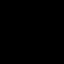

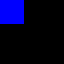

In [320]:
def criar_imagem(width=WIDTH, height=HEIGHT):
  """Cria uma imagem vazia"""
  return np.zeros([width, height, 3], np.uint8)

def mostrar_imagem(img, f=1, v=False, h=False):
  """
  f: fator de de reduçã
  v: se deve refletir a imagem verticalmente antes de mostrar
  h: se deve refletir a imagem horizontalmente antes de mostrar
  """
  cv2_imshow(cv2.resize(img, None, fx=1/f, fy=1/f))
  print()


img = criar_imagem(64, 64)
mostrar_imagem(img, f=1)

img[0:24, 0:24] = (255, 0, 0)
mostrar_imagem(img, f=1)

Observe que a cor fica no formato BGR e não RGB porque a biblioteca cv2 e a imagem tga usa a cor nessa ordem

cor_rgb(255, 0, 0) = (0, 0, 255)


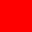


cor_cinza(200) = (200, 200, 200)


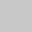


cor_random() = (33, 221, 138)


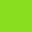


cor_random() = (164, 12, 242)


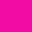


cor_hex('#05f') = (255, 85, 0)


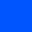


cor_hex('#ff6601') = (1, 102, 255)


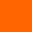


cor_luz(cor_hex('#050'), 2) = (0, 170, 170)


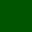

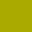


cor_luz(cor_hex('#050'), 1/2) = (0, 42.5, 42.5)


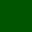

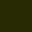


cor_luz(cor_hex('#050'), -2) = (0, 0, 0)


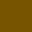

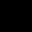

In [534]:
def cor_rgb(r, g, b):
  return b, g, r

def cor_cinza(val):
  return val, val, val

def cor_random():
  return random.randint(0, 255), random.randint(0, 255), random.randint(0, 255)

def cor_hex(string):
  """Tranforma uma cor em hexadecimal em uma cor bgr"""
  assert len(string) - 1 in (3, 6)
  assert string[0] == "#"
  if len(string) - 1 == 3:
    r0, g0, b0 = [int(i, 16) for i in string[1:]]
    r1, g1, b1 = r0, g0, b0
  if len(string) - 1 == 6:
    r1, r0, g1, g0, b1, b0 = [int(i, 16) for i in string[1:]]
  return ((b1<<4) + b0, (g1 << 4) + g0, (r1 << 4) + r0)

def cor_luz(cor, intensidade):
  """Retorna a cor com a intensidade mudada"""
  def clamp(a, v, b):
    """Se v < a, retorna a. Se v > b retorna b. Senão retorna v"""
    return max(a, min(b, v))

  b, g, r = cor
  b, g, r = b * intensidade, g * intensidade, r * intensidade
  b, g, r = clamp(0, b, 255), clamp(0, g, 255), clamp(0, g, 255)
  return b, g, r


img = criar_imagem(32, 32)

# cor_rgb
cor = cor_rgb(255, 0, 0)
print(f"cor_rgb(255, 0, 0) = {cor}")
img[:, :] = cor; mostrar_imagem(img, f=1)

# cor_cinza
cor = cor_cinza(200)
print(f"cor_cinza(200) = {cor}")
img[:, :] = cor; mostrar_imagem(img, f=1)

# cor_random
cor = cor_random()
print(f"cor_random() = {cor}")
img[:, :] = cor
mostrar_imagem(img, f=1)

cor = cor_random()
print(f"cor_random() = {cor}")
img[:, :] = cor; mostrar_imagem(img, f=1)

# cor_hex
cor = cor_hex('#05f')
print(f"cor_hex('#05f') = {cor}")
img[:, :] = cor; mostrar_imagem(img, f=1)

cor = cor_hex('#ff6601')
print(f"cor_hex('#ff6601') = {cor}")
img[:, :] = cor; mostrar_imagem(img, f=1)

# cor_luz
cor_antes = cor_hex('#050')
cor = cor_luz(cor_antes, 2)
print(f"cor_luz(cor_hex('#050'), 2) = {cor}")
img[:, :] = cor_antes; mostrar_imagem(img, f=1)
img[:, :] = cor; mostrar_imagem(img, f=1)

cor_antes = cor_hex('#050')
cor = cor_luz(cor_antes, 1/2)
print(f"cor_luz(cor_hex('#050'), 1/2) = {cor}")
img[:, :] = cor_antes; mostrar_imagem(img, f=1)
img[:, :] = cor; mostrar_imagem(img, f=1)

cor_antes = cor_hex('#750')
cor = cor_luz(cor_antes, -2)
print(f"cor_luz(cor_hex('#050'), -2) = {cor}")
img[:, :] = cor_antes; mostrar_imagem(img, f=1)
img[:, :] = cor; mostrar_imagem(img, f=1)

In [483]:
def criar_vetor(*args):
  """Usa os parâmetro passados e cria uma matriz coluna representando o vetor"""
  return np.array([args]).T


print(f"criar_vetor(1, 2, 3) = \n{criar_vetor(1, 2, 3)}\n")
print(f"criar_vetor(0.3, 0.6) = \n{criar_vetor(1, 2, 3)}\n")

criar_vetor(1, 2, 3) = 
[[1]
 [2]
 [3]]

criar_vetor(0.3, 0.6) = 
[[1]
 [2]
 [3]]



In [539]:
def produto_interno(u, v):
  assert u.shape == v.shape
  assert u.shape[1] == 1
  return (u.T @ v)[0, 0]

def produto_externo(u, v):
  # Esse implementaçao é mais rápida que a do numpy
  # Porque eu sei de antemão qual é o formato dos vetores

  assert u.shape == v.shape
  shape = u.shape
  assert shape in ((3, 1), (2, 1))

  if shape == (3, 1):
    x0, y0, z0 = u[:, 0]
    x1, y1, z1 = v[:, 0]
    return criar_vetor(
      y0 * z1 - y1 * z0,
      z0 * x1 - x0 * z1,
      x0 * y1 - y0 * x1,
    )
  
  if shape == (2, 1):
    x0, y0 = u[:, 0]
    x1, y1 = v[:, 0]
    return x0 * y1 - y0 * x1

def norma(u):
  return sqrt(produto_interno(u, u))

def normalizar(u):
  return u / norma(u)


print(f"produto_interno(criar_vetor(1, 0), criar_vetor(0, 1)) = {produto_interno(criar_vetor(1, 0), criar_vetor(0, 1))}")
print(f"produto_interno(criar_vetor(1, 2), criar_vetor(2, 4)) = {produto_interno(criar_vetor(1, 2), criar_vetor(2, 4))}")
print()

print(f"produto_externo(criar_vetor(1, 0), criar_vetor(0, 1)) = {produto_externo(criar_vetor(1, 0), criar_vetor(0, 1))}")
print(f"produto_externo(criar_vetor(1, 2), criar_vetor(2, 4)) = {produto_externo(criar_vetor(1, 2), criar_vetor(2, 4))}")
print()

print(f"produto_externo(criar_vetor(1, 0, 0), criar_vetor(0, 1, 0)) = \n{produto_externo(criar_vetor(1, 0, 0), criar_vetor(0, 1, 0))}\n")
print(f"produto_externo(criar_vetor(1, 2, 3), criar_vetor(2, 4, 6)) = \n{produto_externo(criar_vetor(1, 2, 3), criar_vetor(2, 4, 6))}\n")
print()

print(f"norma(criar_vetor(1, 0)) = {norma(criar_vetor(1, 0))}")
print(f"norma(criar_vetor(1, 1)) = {norma(criar_vetor(1, 1))}")
print()

print(f"normaliza(criar_vetor(1, 0)) = \n{normalizar(criar_vetor(1, 0))}\n")
print(f"normaliza(criar_vetor(1, 1)) = \n{normalizar(criar_vetor(1, 1))}\n")

produto_interno(criar_vetor(1, 0), criar_vetor(0, 1)) = 0
produto_interno(criar_vetor(1, 2), criar_vetor(2, 4)) = 10

produto_externo(criar_vetor(1, 0), criar_vetor(0, 1)) = 1
produto_externo(criar_vetor(1, 2), criar_vetor(2, 4)) = 0

produto_externo(criar_vetor(1, 0, 0), criar_vetor(0, 1, 0)) = 
[[0]
 [0]
 [1]]

produto_externo(criar_vetor(1, 2, 3), criar_vetor(2, 4, 6)) = 
[[0]
 [0]
 [0]]


norma(criar_vetor(1, 0)) = 1.0
norma(criar_vetor(1, 1)) = 1.4142135623730951

normaliza(criar_vetor(1, 0)) = 
[[1.]
 [0.]]

normaliza(criar_vetor(1, 1)) = 
[[0.70710678]
 [0.70710678]]



In [293]:
def vetor_para_pixel(v, size):
  """Pega um vetor de dimensão 2 e transforma em um ponto da imagem
  
  O vetor deve ter coordenadas de -1 a 1"""
  width, height = size[:2]

  assert v.shape == (2, 1)
  v = v.T[0]
  x, y = v[0], v[1]
  assert -1 <= x <= 1
  assert -1 <= y <= 1

  x = (x + 1) * (width - 1) / 2
  y = (y + 1) * (height - 1) / 2

  return int(x), int(y)



print(f"vetor_para_pixel(criar_vetor(0.4, 0.7), {SIZE}) = {vetor_para_pixel(criar_vetor(0.4, 0.7), SIZE)}")
print(f"vetor_para_pixel(criar_vetor(0, 0), {SIZE}) = {vetor_para_pixel(criar_vetor(0, 0), SIZE)}")
print(f"vetor_para_pixel(criar_vetor(-1, 1), {SIZE}) = {vetor_para_pixel(criar_vetor(-1, 1), SIZE)}")

vetor_para_pixel(criar_vetor(0.4, 0.7), (512, 512)) = (357, 434)
vetor_para_pixel(criar_vetor(0, 0), (512, 512)) = (255, 255)
vetor_para_pixel(criar_vetor(-1, 1), (512, 512)) = (0, 511)


# Leitura do Modelo

Definindo função para ler o modelo. O modelo está armazenado em um arquivo Wavefront obj

Dele é extraido as superfícies que compões o modelo. Cada superfície tem:
- Os vertices da superfície
- O vetor normal de cada um dos vertícies
- Posição na textura correspondente a cada vertície

Para simplificar, usaremos apenas modelos em que a superfície são triângulos, tirando a necessidade de decompor as superfícies em triângulo

[Página da wikipedia sobre arquivos Wavefront .obj](https://en.wikipedia.org/wiki/Wavefront_.obj_file)

Para dar uma noção, o arquivo tem mais ou menos essa cara

```
v -0.000581696 -0.734665 -0.623267
v 0.000283538 -1 0.286843
v -0.117277 -0.973564 0.306907
...

vt  0.532 0.923 0.000
vt  0.535 0.917 0.000
vt  0.542 0.923 0.000
...

vn  0.001 0.482 -0.876
vn  -0.001 0.661 0.751
vn  0.136 0.595 0.792
...

g head
s 1
f 24/1/24 25/2/25 26/3/26
f 24/1/24 26/3/26 23/4/23
f 28/5/28 29/6/29 30/7/30
...
```


In [287]:
class Modelo:
  """Armazena os dados do arquivo Wavefront Obj

  v:  Lista dos vertices do modelo
  vn: Lista das normais dos vertíces
  vt: Lista dos vertices na textura
  f:  lista das superficies.
    Cada superfície é um lista de índices para (v, vt, vn).
    vt e vn são opcionais

  Iterar pelo objeto itera por tuplas com os valores das superfices,
  tirando a necessidade de indexar os outros vetores
  """

  def __init__(self):
    self.v = list()
    self.vn = list()
    self.vt = list()
    self.f = list()

  def __iter__(self):
    for superficie in self.f:
      res = list()
      for elemento in superficie:
        indice_vertice, indice_textura, indice_normal = elemento

        if indice_vertice > 0:
          indice_vertice -= 1
        if indice_textura is not None and indice_textura > 0:
          indice_textura -= 1
        if indice_normal is not None and indice_normal > 0:
          indice_normal -= 1

        try:
          res.append((
              self.v[indice_vertice],
              self.vt[indice_textura] if indice_textura is not None else None,
              self.vn[indice_normal] if indice_normal is not None else None,
          ))
        except IndexError as e:
          print(elemento)
          print(f"{len(self.v)}[{indice_vertice}]")
          print(f"{len(self.vt)}[{indice_textura}]")
          print(f"{len(self.vn)}[{indice_normal}]")
          raise e
      yield res


def carregar_modelo(req):
  """Carrega os dados de uma arquivo Wavefront Obj e retorna um Modelo"""

  def filtra_vazios(v):
    """Filtra elementos vazios de uma lista ou gerador"""
    yield from (i for i in v if len(i))

  res = Modelo()

  linhas = req.text.split("\n")
  linhas = filtra_vazios(linhas)

  for linha in linhas:
    dados = linha.split(" ")
    dados = list(filtra_vazios(dados))

    if dados[0] == "v":
      vetor = (float(i) for i in dados[1:4]) # Vetor com três coordenadas
      vetor = criar_vetor(*vetor)
      res.v.append(vetor)
    elif dados[0] == "vt":
      vetor = [float(i) for i in dados[1:3]] # Vetor com duas coordenadas
      vetor = criar_vetor(*vetor)
      res.vt.append(vetor)
    elif dados[0] == "vn":
      vetor = (float(i) for i in dados[1:4]) # Vetor com três coordenadas
      vetor = criar_vetor(*vetor)
      res.vn.append(vetor)
    elif dados[0] == "f":
      superficie = list()
      for elemento in dados[1:]:
        elemento = elemento.split("/")
        indice_vertice = int(elemento[0])

        try:
          indice_textura = int(elemento[1])
        except IndexError: # Esse elemento possui apenas indice_vertice
          indice_textura = None
        except ValueError: # O indice da textura está vazio
          indice_textura = None

        try:
          indice_normal = int(elemento[2])
        except IndexError: # Esse elemento possui apenas indice_vertice
          indice_normal = None
        except ValueError: # O indice da textura está vazio
          indice_normal = None

        superficie.append((indice_vertice, indice_textura, indice_normal))

      res.f.append(superficie)              
  
  return res

# Carregando Texturas


Função para carregar uma imagem TGA

[Especificação do arquivo TGA nesse link](https://www.fileformat.info/format/tga/egff.htm)

Note que a função não implementa toda especificação, apenas o necessário para este projeto. Em imagens que usa outras partes da implementação será emitido um erro

In [251]:
def flip_imagem(img, v=False, h=False):
  """Reflete a imagem

  Por padrão, não causa reflexão
  
  v: se é para refletir verticalmente
  h: se é para refletir horizontalmente

  Note que a imagem é sobrescrita
  """
  if (v, h) == (False, False):
    return img
  if (v, h) == (True, False):
    return cv2.flip(img, 0, img)
  if (v, h) == (False, True):
    return cv2.flip(img, 1, img)
  if (v, h) == (True, True):
    return cv2.flip(img, -1, img)

In [252]:
# TODO traduzir o código para ele não ficar em duas líguas

def carregar_tga(req):
  """Carrega uma imagem tga da url e retorna um np.array com a imagem

  O retorno tem três dimentões, as duas primeiras para posição do pixel
  e a terceiara para as componentes da cor (azul, verde, vermelho)
  """

  tga = bytearray(req.content)  # Le arquivo da url
  tga = tga[::-1]  # Invertendo lista porque pop() é mais eficiente que pop(0)

  def ler_cor(tga):
    return (float(tga.pop()), float(tga.pop()), float(tga.pop()))

  def ler_int(tga, length: int = 1):
    return int.from_bytes([tga.pop() for _ in range(length)], "little")

  def pular_bytes(tga, length: int = 1):
    for _ in range(length):
      tga.pop()


  # > HEADER
  # ID length
  image_id_length = ler_int(tga)

  # Color map type
  color_map = ler_int(tga)
  assert color_map == 0, f"color_map={color_map} não implementado!"

  # image type (Compression and color types)
  image_type = ler_int(tga)
  assert image_type in [2, 10], f"image_type={image_type} não implementado!"
  rle = image_type == 10

  # >> Color Map specification
  # Ignorado porque color map type é 0
  pular_bytes(tga, 5)

  # >> Image specification
  # X and Y origin
  origin = (ler_int(tga, 2), ler_int(tga, 2))
  assert origin == (0, 0), \
    f"origin={origin} não implementado! Precisa ser (0, 0)!"

  # Image width and height
  width, height = ler_int(tga, 2), ler_int(tga, 2)
  
  # Pixel Depth
  color_depth = ler_int(tga)
  assert color_depth == 24, f"color_depth={color_depth} não implementado!"

  image_descriptor = ler_int(tga)
  assert (image_descriptor & 0b1100111) == 0, \
    f"image_descriptor={image_descriptor} não implementado!"
  flip_horizontally = (image_descriptor & 0b0001000) != 0;
  flip_vertically   = (image_descriptor & 0b0010000) == 0;

  # > image and color map data
  # Image ID
  pular_bytes(tga, image_id_length)
  # Color Map (Asserted to no color map)
  # Image data
  img = np.zeros((width * height, 3), np.uint8)
  if rle:
    i = 0
    while i < width * height:
      packet_size = ler_int(tga)
      if packet_size & 0b10000000 == 0:
        # Raw packet
        for _ in range(packet_size + 1):
          img[i] = ler_cor(tga)
          i += 1
      else:
        # RLE packet
        packet_size = packet_size & 0b01111111
        cor = ler_cor(tga)
        for _ in range(packet_size + 1):
          img[i] = cor
          i += 1
  else:
    for i in range(width * height):
      img[i] = ler_cor(tga)

  img = img.reshape(width, height, 3)
  return flip_imagem(img, v=flip_vertically, h=flip_horizontally)

# Importando arquivos

Estou importando os arquivos do tutorial

In [253]:
URLs = {
  "african_head.obj": "https://raw.githubusercontent.com/ssloy/tinyrenderer/master/obj/african_head/african_head.obj",
  "african_head_diffuse.tga": "https://raw.githubusercontent.com/ssloy/tinyrenderer/master/obj/african_head/african_head_diffuse.tga",
  "diablo3_pose.obj": "https://raw.githubusercontent.com/ssloy/tinyrenderer/master/obj/diablo3_pose/diablo3_pose.obj",
  "diablo3_pose_diffuse.tga": "https://raw.githubusercontent.com/ssloy/tinyrenderer/master/obj/diablo3_pose/diablo3_pose_diffuse.tga",
}

In [255]:
REQs = {k: requests.get(v) for k, v in URLs.items()}

In [254]:
MODELOS = {
  "african_head": carregar_modelo(REQs['african_head.obj']),
  "diablo3_pose": carregar_modelo(REQs['diablo3_pose.obj']),
}

TEXTURAS = {
  "african_head_diffuse": carregar_tga(REQs["african_head_diffuse.tga"]),
  "diablo3_pose_diffuse": carregar_tga(REQs["diablo3_pose_diffuse.tga"]),
}

Essas foram as texturas importadas

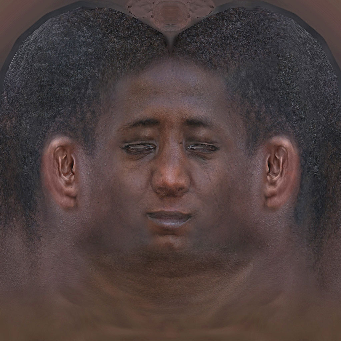

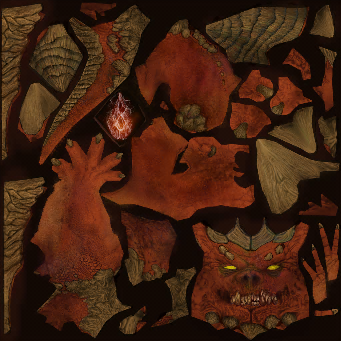

In [256]:
mostrar_imagem(TEXTURAS["african_head_diffuse"], f=3)
mostrar_imagem(TEXTURAS["diablo3_pose_diffuse"], f=3)

Não dá para mostrar os modelos importados, porque por enquanto eles são apenas um conjunto de listas

In [257]:
print(MODELOS["african_head"])
print(MODELOS["diablo3_pose"])

# Wireframe Redering

Para termos uma noção de como é o modelo, vamos desenhar as linhas de cada uma das superfícies ignorando o valor de uma das coordenadas.

Assim quando eu ignoro a coordenada $z$, é como se eu estivesse projetando os pontos em um plano perpendicular aquela linha

In [670]:
def desenhar_eixos(img, T, fonte_luz=None, k=0.1, tickness=1):
  """Desenha os eixos na imagem
  
  T: matriz da transformação T: R^3 -> R^2
  k: tamanho em que os versores vão aparecer na imagem

  Note que a imagem é sobrescrita
  """

  o = T @ criar_vetor(0, 0, 0)
  x = T @ criar_vetor(k, 0, 0)
  y = T @ criar_vetor(0, k, 0)
  z = T @ criar_vetor(0, 0, k)
  if fonte_luz is not None:
    f = T @ (k * fonte_luz)

  p1 = vetor_para_pixel(o, img.shape)

  p2 = vetor_para_pixel(x, img.shape)
  cv2.arrowedLine(img, p1, p2, cor_hex("#f00"), tickness)

  p2 = vetor_para_pixel(y, img.shape)
  cv2.arrowedLine(img, p1, p2, cor_hex("#0f0"), tickness)
  
  p2 = vetor_para_pixel(z, img.shape)
  cv2.arrowedLine(img, p1, p2, cor_hex("#00f"), tickness)

  if fonte_luz is not None:
    p2 = vetor_para_pixel(f, img.shape)
    cv2.arrowedLine(img, p1, p2, cor_hex("#ff0"), tickness)

  return img

In [259]:
REMOVER_COORDENADA = {
  "x": np.array([[0, 1, 0],
                  [0, 0, 1]]),

  "y": np.array([[1, 0, 0],
                  [0, 0, 1]]),

  "z": np.array([[1, 0, 0],
                  [0, 1, 0]]),
}

In [295]:
def render_wireframe(
  img,
  modelo,
  cor=cor_hex("#fff"),
  coordenada="z",
  tickness=1,
  mostrar_eixos=False
):
  """Desenha o wireframe na imagem
  
  Note que a imagem é sobrescrita
  """
  flip_imagem(img, v=True)


  for f in modelo:
    v, _, _ = f[-1]
    for u, _, _ in f:
      p1 = vetor_para_pixel(REMOVER_COORDENADA[coordenada] @ u, img.shape)
      p2 = vetor_para_pixel(REMOVER_COORDENADA[coordenada] @ v, img.shape)
      cv2.line(img, p1, p2, cor, tickness)
      v = u

  if mostrar_eixos:
    desenhar_eixos(img, REMOVER_COORDENADA[coordenada], tickness=4 * tickness)

  flip_imagem(img, v=True)
  return img

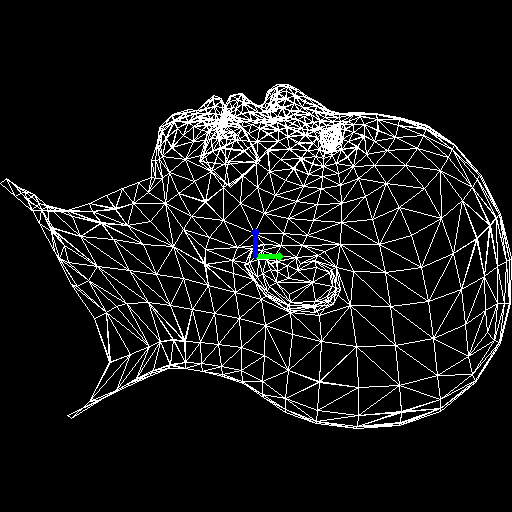

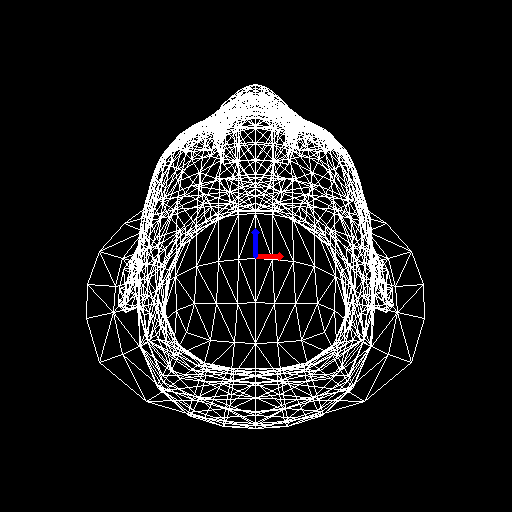

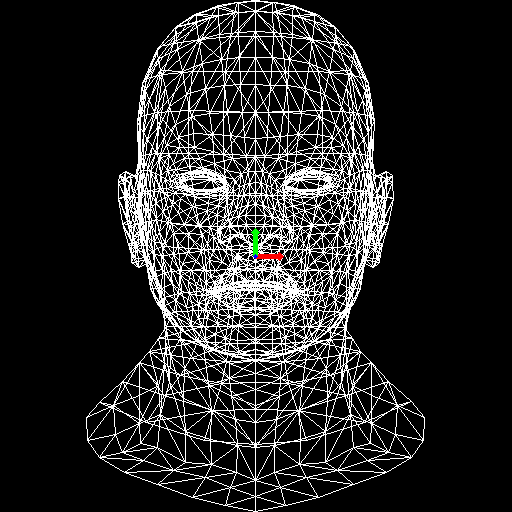

In [558]:
modelo = MODELOS["african_head"]

for c in "xyz":
  img = criar_imagem()
  render_wireframe(img, modelo, coordenada=c, mostrar_eixos=True)
  mostrar_imagem(img)

# Desenhando triângulos

Para fazer a renderização como queremos, vamos ter que fazer um algoritmo que dê para customizar facilmente a forma como os pixels do triângulo são desenhados

Para desenharmos o triângulo vamos seguir o seguinte pseudo-código:

```python
for pixel in area_contendo_triangulo(triangulo):
  if triangulo_contem_pixel(triangulo, pixel):
    # Pixel faz parte do triângulo
    desenha_pixel(img, pixel)
```

Considere o triângulo $\Delta ABC$ cujos vertíces são:
- $A = (A_x, A_y)$
- $B = (B_x, B_y)$ 
- $C = (C_x, C_y)$

## Encontrando retângulo que contém o triângulo

Encontrar uma área que contenha o triângulo é simples, ele vai estar dentro de um retângulo que engloba todos os pixels que tenham a coordenada x entre a menor e a maior coordenada x dos vertices do triângulo e a coordenada y entre a menor e a maior coordenada y dos vertices do triângulo. Ou de um jeito mais simples, esse o retângulo é:

$$
Retângulo =
\{
  P = (P_x, P_y)
  \mid min(A_x, B_x, C_x) < P_x < max(A_x, B_x, C_x)
  \land min(A_y, B_y, C_y) < P_y < max(A_y, B_y, C_y)
\}
$$

In [527]:
def retangulo_contendo_triangulo(triangulo):
  a, b, c = triangulo

  menor_x = min(p[0, 0] for p in triangulo)
  maior_x = max(p[0, 0] for p in triangulo)
  menor_y = min(p[1, 0] for p in triangulo)
  maior_y = max(p[1, 0] for p in triangulo)

  return (menor_x, maior_x), (menor_y, maior_y)

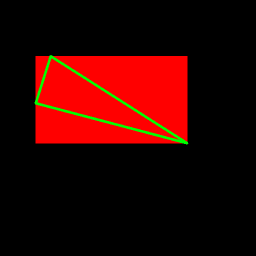

In [486]:
# O randint pode resultar no segundo parâmetro, por isso tem que diminuir 1
a = random.randint(0, WIDTH - 1), random.randint(0, HEIGHT - 1)
b = random.randint(0, WIDTH - 1), random.randint(0, HEIGHT - 1)
c = random.randint(0, WIDTH - 1), random.randint(0, HEIGHT - 1)

triangulo = [criar_vetor(*a), criar_vetor(*b), criar_vetor(*c)]

img = criar_imagem()

(x0, x1), (y0, y1) = retangulo_contendo_triangulo(triangulo)
cor = cor_hex("#f00")
for x in range(x0, x1 + 1):
  for y in range(y0, y1 + 1):
    # Note que indexa a linha primeiro (eixo y) e depois a coluna (eixo x)
    img[y, x] = cor

cv2.line(img, a, b, cor_hex("#0f0"), 3)
cv2.line(img, b, c, cor_hex("#0f0"), 3)
cv2.line(img, c, a, cor_hex("#0f0"), 3)

mostrar_imagem(img, f=2)

## Encontrando quais pontos pertecem ao triângulo

Agora precisamos descobrir se o pixel está dentro de um triângulo

Para isso usaremos coordenadas baricêntricas
([Artigo do Wikipedia](https://en.wikipedia.org/wiki/Barycentric_coordinate_system))

A ideia da coordenada baricẽntrica é representar um ponto como a combinação linear de cada um dos vertices que compõe o triângulo 

Digamos que as coordenadas baricêntricas do ponto $P = (P_x, P_y)$ em relação ao triângulo $\Delta ABC$ seja $(\alpha, \beta, \gamma)$. Ou seja:

$P = \alpha A + \beta B + \gamma C$

Por causa que o $dim(\mathbb{R}^2) = 2$, sabemos $\{A, B, C\}$ não é uma base, e portanto a combinação linear que resulta no ponto $P$ não é única

Para que as coordenadas baricêntricas sejam única, adicionamos a restrição
$\alpha + \beta + \gamma = 1$:

\begin{cases}
P = \alpha A + \beta B + \gamma C \\
\alpha + \beta + \gamma = 1
\end{cases}

Agora vamos encontrar os valores de $\alpha, \beta$ e $\gamma$

Como $\alpha + \beta + \gamma = 1$, temos que $\alpha = 1 - \beta - \gamma$

Assim \
$P = (1 - \beta - \gamma) A + \beta B + \gamma C$ \
$P - A = \beta B - \beta A + \gamma C - \gamma A$ \
$\vec{AP} = \beta \vec{AB} + \gamma \vec{AC}$

Note que como $\{\vec{AB}, \vec{AC}\}$ é base, existe $\beta$ e $\gamma$ únicos que tornam a equação verdadeira, como $\alpha = 1 - \beta - \gamma$, temos que para o ponto $P$ as coordenadas baricêntricas é única

Seguindo \
$\beta \vec{AB} + \gamma \vec{AC} - \vec{AP} = \vec{0}$ \
$\beta \vec{AB} + \gamma \vec{AC} + \vec{PA} = \vec{0}$

Portanto encontramos as equações:

\begin{cases}
\beta \vec{AB}_x + \gamma \vec{AC}_x + \vec{PA}_x = 0\\
\beta \vec{AB}_y + \gamma \vec{AC}_y + \vec{PA}_y = 0
\end{cases}

Que podemos escrever matricialmente como:

\begin{cases}
\begin{bmatrix}
  \beta & \gamma & 1
\end{bmatrix}
\begin{bmatrix}
  \vec{AB}_x \\ \vec{AC}_x \\ \vec{PA}_x
\end{bmatrix}
\\ \\
\begin{bmatrix}
  \beta & \gamma & 1
\end{bmatrix}
\begin{bmatrix}
  \vec{AB}_y \\ \vec{AC}_y \\ \vec{PA}_y
\end{bmatrix}
\end{cases}

Ou seja estamos porcurando por um vetor $(\beta, \gamma, 1)$ que seja ortogonal a $(\vec{AB}_x, \vec{AC}_x, \vec{PA}_x)$ e a $(\vec{AB}_y, \vec{AC}_y, \vec{PA}_y)$

Para encontrarmos um vetor que seja ortogonal a esse dois, bata fazer o produto externo: \
$
(\lambda\beta, \lambda\gamma, \lambda)
=
(\vec{AB}_x, \vec{AC}_x, \vec{PA}_x)
\times
(\vec{AB}_y, \vec{AC}_y, \vec{PA}_y)
$

In [528]:
def coordenadas_baricentricas(P, triangulo):
  A, B, C = triangulo

  AB = B - A
  AC = C - A
  PA = A - P

  vec_x = criar_vetor(AB[0, 0], AC[0, 0], PA[0, 0])
  vec_y = criar_vetor(AB[1, 0], AC[1, 0], PA[1, 0])

  cross = produto_externo(vec_x, vec_y)
  if cross[0, 0] == cross[1, 0] == cross[2, 0] == 0:
    return (0, 0, 0)

  λ = cross[2, 0]
  if λ == 0:
    return None # Não é um triângulo (pontos colineares)

  β = cross[0, 0] / λ
  γ = cross[1, 0] / λ
  α = 1 - β - γ 

  return (α, β, γ)

Se pelo mesno uma coordendas baricêntricas dos ponto for negativa, sabemos que está fora do triângulo. Senão sabemos que está detro

In [517]:
def triangulo_contem_pixel(triangulo, pixel):
  P = criar_vetor(*pixel)
  coordenadas = coordenadas_baricentricas(P, triangulo)
  if coordenadas is None:
    return False # Não é um triângulo (Pontos colineares)
  return all(c >= 0 for c in coordenadas)

E agora podemos desenhar nosso triângulo

In [516]:
def desenha_triangulo(img, triangulo, cor):
  """Desenha um triângulo na imagem
  
  triangulo: triângulo composto de pontos na imagem
  """
  (x0, x1), (y0, y1) = retangulo_contendo_triangulo(triangulo)
  for x in range(x0, x1 + 1):
    for y in range(y0, y1 + 1):
      if triangulo_contem_pixel(triangulo, (x, y)):
        img[y, x] = cor

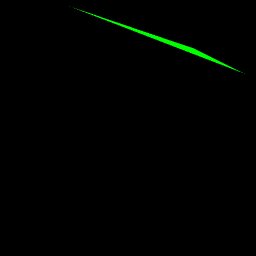

In [515]:
# O randint pode resultar no segundo parâmetro, por isso tem que diminuir 1
a = random.randint(0, WIDTH - 1), random.randint(0, HEIGHT - 1)
b = random.randint(0, WIDTH - 1), random.randint(0, HEIGHT - 1)
c = random.randint(0, WIDTH - 1), random.randint(0, HEIGHT - 1)

triangulo = [criar_vetor(*a), criar_vetor(*b), criar_vetor(*c)]

img = criar_imagem(WIDTH, HEIGHT)

desenha_triangulo(img, triangulo, cor_hex("#0f0"))

mostrar_imagem(img, f=2)

Otimizando algoritmo, porque ele será executado diversas vezes

In [529]:
def coordenadas_baricentricas(P, triangulo):
  # Evita a criação de um np.array
  def produto_externo(u, v):
    x0, y0, z0 = u
    x1, y1, z1 = v
    return (
      y0 * z1 - y1 * z0,
      z0 * x1 - x0 * z1,
      x0 * y1 - y0 * x1,
    )

  A, B, C = triangulo

  AB = B - A
  AC = C - A
  PA = A - P

  vec_x = [AB[0, 0], AC[0, 0], PA[0, 0]]
  vec_y = [AB[1, 0], AC[1, 0], PA[1, 0]]

  cross = produto_externo(vec_x, vec_y)
  if cross[0] == cross[1] == cross[2] == 0:
    return (0, 0, 0)

  λ = cross[2]
  if λ == 0:
    return None # Não é um triângulo (pontos colineares)

  β = cross[0] / λ
  γ = cross[1] / λ
  α = 1 - β - γ 

  return (α, β, γ)

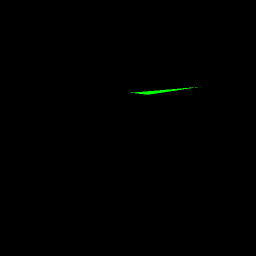

In [531]:
# O randint pode resultar no segundo parâmetro, por isso tem que diminuir 1
a = random.randint(0, WIDTH - 1), random.randint(0, HEIGHT - 1)
b = random.randint(0, WIDTH - 1), random.randint(0, HEIGHT - 1)
c = random.randint(0, WIDTH - 1), random.randint(0, HEIGHT - 1)

triangulo = [criar_vetor(*a), criar_vetor(*b), criar_vetor(*c)]

img = criar_imagem(WIDTH, HEIGHT)

desenha_triangulo(img, triangulo, cor_hex("#0f0"))
# cv2.line(img, a, b, cor_hex("#00f"), 3)
# cv2.line(img, b, c, cor_hex("#00f"), 3)
# cv2.line(img, c, a, cor_hex("#00f"), 3)

mostrar_imagem(img, f=2)

# Flat Shading Render

Vamos usar o algoritmo de desenhar o triângulo e desenhar o modelo usando cores aleatórias

In [560]:
def render_triangulos(
  img,
  modelo,
  coordenada="z",
  tickness=1,
  mostrar_eixos=False
):
  """Desenha o modelos com triângulos com cores aleatórias
  
  Note que a imagem é sobrescrita
  """
  flip_imagem(img, v=True)

  for f in modelo:
    u, _, _ = f[0]
    v, _, _ = f[1]
    w, _, _ = f[2]

    u = REMOVER_COORDENADA[coordenada] @ u
    v = REMOVER_COORDENADA[coordenada] @ v
    w = REMOVER_COORDENADA[coordenada] @ w

    u = vetor_para_pixel(u, img.shape)
    v = vetor_para_pixel(v, img.shape)
    w = vetor_para_pixel(w, img.shape)

    u = criar_vetor(*u)
    v = criar_vetor(*v)
    w = criar_vetor(*w)

    desenha_triangulo(img, (u, v, w), cor_random())

  if mostrar_eixos:
    desenhar_eixos(img, REMOVER_COORDENADA[coordenada], tickness=4 * tickness)

  flip_imagem(img, v=True)
  return img

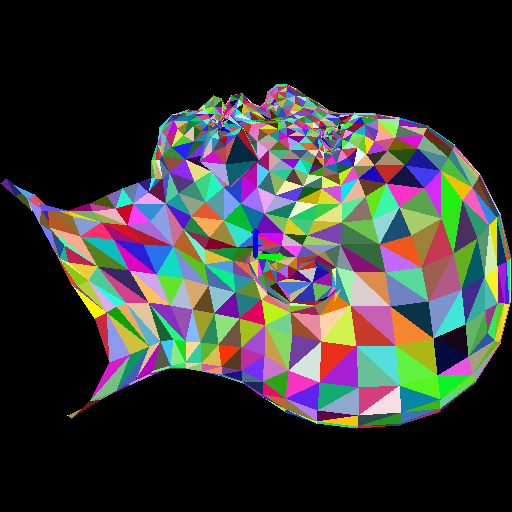

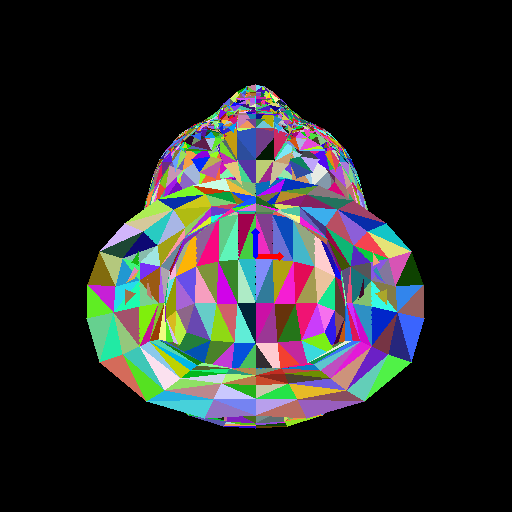

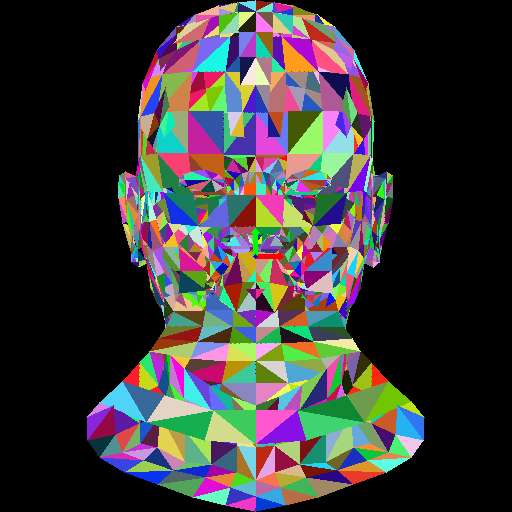

In [561]:
modelo = MODELOS["african_head"]

for c in "xyz":
  img = criar_imagem()
  render_triangulos(img, modelo, coordenada=c, mostrar_eixos=True)
  mostrar_imagem(img)

Em vez de usar cores aleatórias, colocar uma fonte de luz na renderização, e computar a intensidade com que cada suprefície é iluminada usando produto interno

In [671]:
def render_triangulos(
  img,
  modelo,
  fonte_luz,
  cor=cor_hex("#fff"),
  coordenada="z",
  tickness=1,
  mostrar_eixos=False
):
  """Desenha o modelos com triângulos com cores aleatórias
  
  Note que a imagem é sobrescrita
  """
  flip_imagem(img, v=True)

  for f in modelo:
    u, _, _ = f[0]
    v, _, _ = f[1]
    w, _, _ = f[2]

    normal = normalizar(produto_externo(v - u, w - u))
    intensidade = produto_interno(normal, fonte_luz)

    if intensidade <= 0:
      continue

    u = REMOVER_COORDENADA[coordenada] @ u
    v = REMOVER_COORDENADA[coordenada] @ v
    w = REMOVER_COORDENADA[coordenada] @ w

    u = vetor_para_pixel(u, img.shape)
    v = vetor_para_pixel(v, img.shape)
    w = vetor_para_pixel(w, img.shape)

    u = criar_vetor(*u)
    v = criar_vetor(*v)
    w = criar_vetor(*w)

    desenha_triangulo(img, (u, v, w), cor_luz(cor, intensidade))

  if mostrar_eixos:
    desenhar_eixos(
      img,
      REMOVER_COORDENADA[coordenada],
      fonte_luz=fonte_luz,
      tickness=4 * tickness
    )

  flip_imagem(img, v=True)
  return img

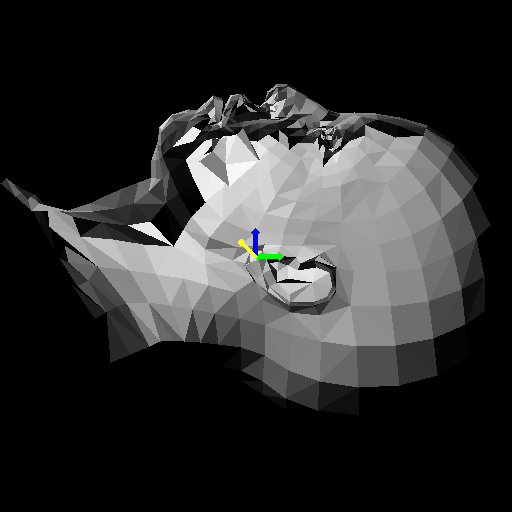

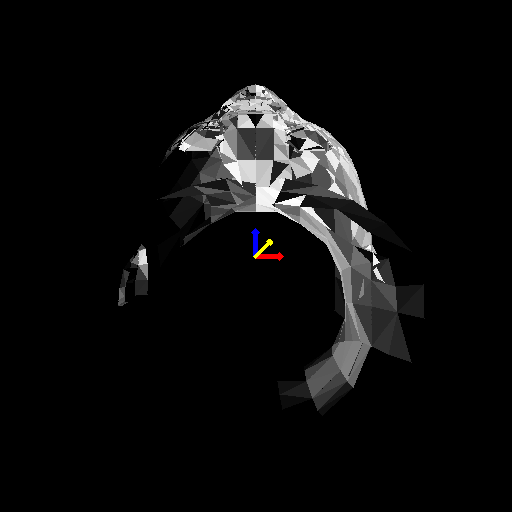

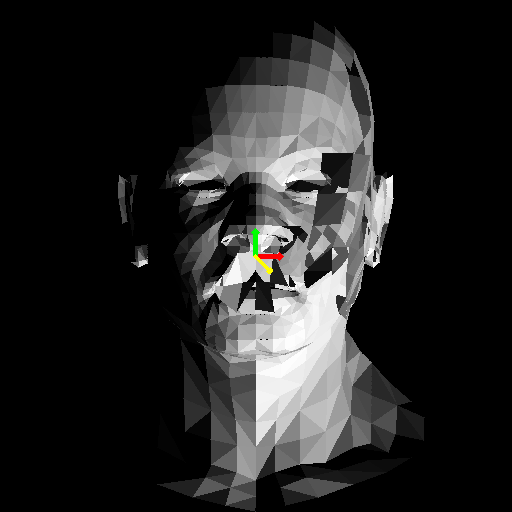

In [672]:
modelo = MODELOS["african_head"]

fonte_luz = normalizar(criar_vetor(1, -1, 1))
for c in "xyz":
  img = criar_imagem()
  render_triangulos(img, modelo, fonte_luz, coordenada=c, mostrar_eixos=True)
  mostrar_imagem(img)

# ZBuffer

In [664]:
def baricentricas_contem_pixel(coordenadas):
  if coordenadas is None:
    return False # Não é um triângulo (Pontos colineares)
  return all(c >= 0 for c in coordenadas)

def desenha_triangulo_zbuffer(img, zbuffer, triangulo, cor, coordenada="z"):
  """Desenha o triângulo na imagem
  
  triangulo: triângulo composto de vetores tridimensionais
  """

  v0, v1, v2 = triangulo

  p0 = REMOVER_COORDENADA[coordenada] @ v0
  p1 = REMOVER_COORDENADA[coordenada] @ v1
  p2 = REMOVER_COORDENADA[coordenada] @ v2

  p0 = vetor_para_pixel(p0, img.shape)
  p1 = vetor_para_pixel(p1, img.shape)
  p2 = vetor_para_pixel(p2, img.shape)

  p0 = criar_vetor(*p0)
  p1 = criar_vetor(*p1)
  p2 = criar_vetor(*p2)

  (x0, x1), (y0, y1) = retangulo_contendo_triangulo([p0, p1, p2])
  for x in range(x0, x1 + 1):
    for y in range(y0, y1 + 1):
      baricentricas = coordenadas_baricentricas(criar_vetor(x, y), (p0, p1, p2))
      if baricentricas_contem_pixel(baricentricas):
        alfa, beta, gama = baricentricas
        v = alfa*v0 + beta*v1 + gama*v2

        if coordenada == "x":
          z = v[0, 0]
        elif coordenada == "y":
          z = v[1, 0]
        elif coordenada == "z":
          z = v[2, 0]

        if zbuffer[y, x] < z:
          zbuffer[y, x] = z
          img[y, x] = cor

In [673]:
def render_zbuffer(
  img,
  modelo,
  fonte_luz,
  cor=cor_hex("#fff"),
  coordenada="z",
  tickness=1,
  mostrar_eixos=False
):
  """Desenha o modelos com triângulos com cores aleatórias
  
  Note que a imagem é sobrescrita
  """
  zbuffer = -np.inf * np.ones((img.shape[0], img.shape[1]))

  flip_imagem(img, v=True)
  flip_imagem(zbuffer, v=True)

  for f in modelo:
    u, _, _ = f[0]
    v, _, _ = f[1]
    w, _, _ = f[2]

    normal = normalizar(produto_externo(v - u, w - u))
    intensidade = produto_interno(normal, fonte_luz)

    desenha_triangulo_zbuffer(
      img,
      zbuffer,
      (u, v, w),
      cor_luz(cor, intensidade),
      coordenada=coordenada,
    )

  if mostrar_eixos:
    desenhar_eixos(
      img,
      REMOVER_COORDENADA[coordenada],
      fonte_luz=fonte_luz,
      tickness=4 * tickness
    )

  flip_imagem(img, v=True)
  flip_imagem(zbuffer, v=True)
  return img, zbuffer

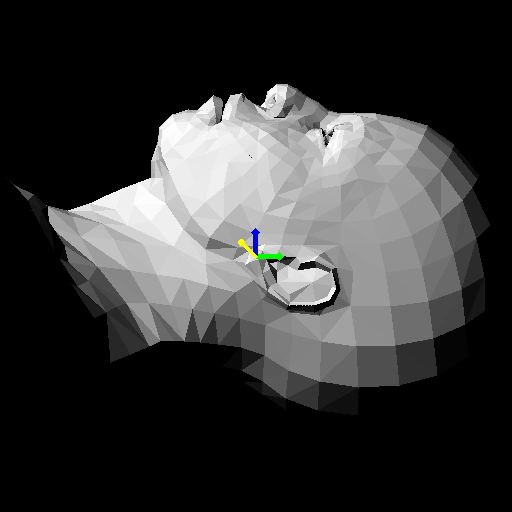

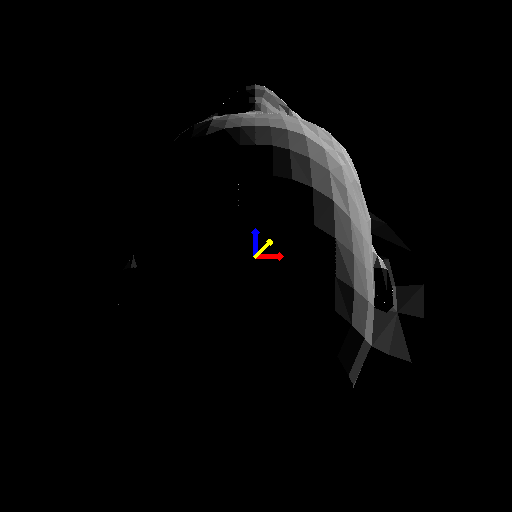

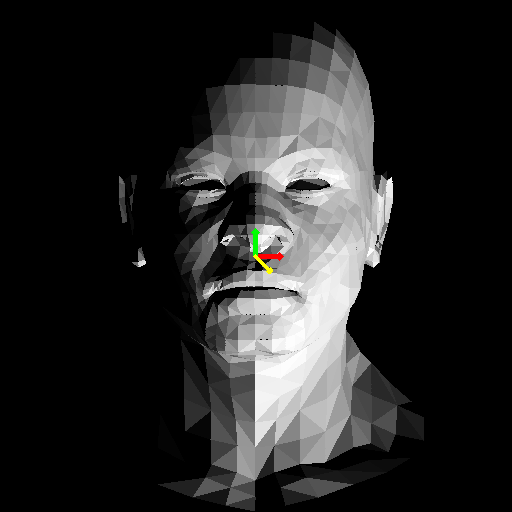

In [675]:
modelo = MODELOS["african_head"]

fonte_luz = normalizar(criar_vetor(1, -1, 1))
for c in "xyz":
  img = criar_imagem()
  img, zbuffer = render_zbuffer(img, modelo, fonte_luz, coordenada=c, mostrar_eixos=True)
  # zbuffer = np.vectorize(lambda x: max(0, min(255, x)))(255*zbuffer)
  mostrar_imagem(img)
  # mostrar_imagem(zbuffer)